In [39]:
import os
import warnings
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from BinaryFileUnpack import BinaryFileUnpack

In [40]:
# Function to get decreasing midline of damping function
def midline(t, c, d):
    # c is initial pressure
    # d quantifies the rate of decrease of pressure
    return c + d * t

# Fitting damping model to data
def damping(t, A, gamma, omega, phi, c, d):
    warnings.filterwarnings('ignore')
    # First term is equation for damped harmonic motion
    # Second term (midline function) accounts for the gradual loss of pressure in the geyser
    return A * np.exp(-gamma*t) * np.cos(omega*t - phi) + midline(t, c, d)

# Identifying and obtaining parameters for periodic motion based off damping function
def periodic_range(func, time, P, fs:int):
    # Helper function to change intital conditions of curve fitting
    def alter_cond(time_range, s, e, action):
        if time_range < 8:  # Change time interval to max 8.
            time_range += 1
            e = s + int(time_range * fs)
        else:  # If that does not work, alter start period and reset time range
            time_range = 5
            # Find next local extrema, and start from there
            # Must offset from current extrema to find next extrema
            min_ind = signal.find_peaks(-P[np.argmin(P):], prominence=0.0003)[0][0]
            max_ind = signal.find_peaks( P[np.argmin(P):], prominence=0.0003)[0][0]
            s += min(min_ind, max_ind)
            e = s + int(time_range * fs)
        if action == "err": assert e < time.shape[0], "Not a valid oscillation, redo experiment."
        elif action == "break": return 0, 0, 0
        return time_range, s, e

    std_dev = np.ones(5)  # Minimum Standard deviation of the parameters
    params = np.ones(5)  # Optimal Parameters of damped motion
    s_opt = 0
    e_opt = 0
    time_range = 5  # Time interval considered for oscillation fitting

    s = signal.find_peaks(P[np.argmin(P):], prominence=0.0003)[0][0] + np.argmin(P)
    e = s + int(time_range * fs)
    assert e < time.shape[0], "Not a valid oscillation, redo experiment."
    while True:
        try:
            popt, pcov = curve_fit(func, time[0:e-s], P[s:e])
        except RuntimeError:  # Oscillation not detected
            time_range, s, e = alter_cond(time_range, s, e, action="err")
        else:  # Oscillation detected
            omega_std_dev = np.sqrt(pcov[2][2])
            if omega_std_dev < std_dev[2]:
                params = popt
                std_dev = np.sqrt(np.diag(pcov))
                s_opt = s
                e_opt = e
            if omega_std_dev > 1e-3 or omega_std_dev > popt[2] * 1e-2:
                time_range, s, e = alter_cond(time_range, s, e, action="break")
                if time_range == 0: break
            else:
                break
    return params, std_dev, s_opt/fs, e_opt/fs

# Obtain Y value of experiment
def getY(pressure, sens_ind, H):
    # Linear model
    f = lambda x, b0, b1: b0 + b1*x
    # Import Calibration Data
    df = pd.read_csv(r"C:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\calibration_data_constrict.csv")
    ytest = df["Y* (cm)"].to_numpy()
    try:
        P = df[f"P{sens_ind+1} (Raw)"].to_numpy()
    except KeyError:
        raise ValueError(f"Calibration Data for requested sensor {sens_ind+1} does not exist.")
    # Corrections
    if sens_ind == 0 or sens_ind == 1:
        Htest = 29
        Hb = 76
        # Accounting for the water that does not participate in oscillation 
        ext_pres_cali = (997.76*9.81*((Hb-Htest)/100))*1e-5
        ext_pres_act = (997.76*9.81*((Hb-H)/100))*1e-5
        popt = curve_fit(f, P - ext_pres_cali, ytest, absolute_sigma=True)[0]
        y = f(pressure - ext_pres_act, *popt)
        y_stdev = 0
        for i in range(len(ytest)):
            y_stdev += (ytest[i] - f(P[i] - ext_pres_act, *popt))**2 / len(ytest)
    else:
        popt = curve_fit(f, P, ytest, absolute_sigma=True)[0]
        y = f(pressure, *popt)
        y_stdev = 0
        for i in range(len(ytest)):
            y_stdev += (ytest[i] - f(P[i], *popt))**2 / len(ytest)

    return y+H, y_stdev

# Run to extract all oscillation details in given parent_dir
def osc_details(parent_dir, test_summary, H, verbose=True):
    Hb = 76
    home = os.getcwd()
    os.chdir(parent_dir)
    for file in os.listdir():
        try: name, ext = file.split('.')
        except ValueError: # Directory, not a file
            dir = file
            # Recurse to find oscillations in new directory
            osc_details(dir, test_summary, H, verbose)
        else: 
            if ext != 'bin': # Not .bin file
                continue
            if name[:3] != 'DAQ': # Not oscillation
                continue

            # File format is 'DAQ_{dir}_Y{y_value}-{date}-{time}.bin'
            # Use str.split accordingly to get x_value and y_value
            x_value = name.split('-')[0].split('_')[ 1][1:].replace('p', '.')
            y_value = name.split('-')[0].split('_')[-1][1:].replace('p', '.')

            # Convert to floating-point numbers
            x = float(x_value[:-2])
            y_obs = float(y_value[:-2])
            if x_value[-2:] == 'in':
                x *= 2.54
            if y_value[-2:] == 'in':
                y_obs *= 2.54
            # Convert to X as defined in Max's illustration
            x -= (Hb - H)

            # Get file details with BinaryFileUnpack class
            obj = BinaryFileUnpack(file)
            fs = int(obj.fs)
            
            # Use sensor 1 for oscillation data
            # Filter the high-frequency noise from data
            P0 = obj.P[0]
            bound_freq = 2.2
            nyq_freq = obj.fs // 2
            b, a = signal.butter(1, bound_freq/nyq_freq, 'lowpass')
            filteredP0 = signal.filtfilt(b, a, P0)
            
            # Get the parameters
            popt, std_dev, start, end = periodic_range(damping, obj.time, filteredP0, fs)
            
            # Use sensor 3 to obtain average y values for experiment
            P2 = obj.P[2]
            bound_freq = 2.2
            nyq_freq = obj.fs // 2
            b, a = signal.butter(1, bound_freq/nyq_freq, 'lowpass')
            filteredP2 = signal.filtfilt(b, a, P2)

            y, y_stddev = getY(np.mean(filteredP2), 2, H)

            # Getting data string for the csv file
            data_string = f"{x},{y},{y_stddev},{start},{end},{','.join([str(param) for param in popt])},{','.join([str(sd) for sd in std_dev])}"
            test_summary.append(data_string)

            if verbose: 
                if verbose: print(f"For X{x_value}, Y{y_value}:")
                print(f"\tDuration: {start} to {end}\n\tomega = {popt[2]}\n\tstd_dev = {std_dev[2]}\n\t")
                s = int(start * fs)
                e = int(end * fs)
                fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
                ax.plot(obj.time[s:e], P0[s:e], color='steelblue', label=f'data')
                ax.plot(obj.time[s:e], damping(obj.time[:e-s], *popt), color='lime', alpha=0.6, label=f'fitted curve')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Pressure (bar)')
                ax.set_title(f"X = {round(x, 2)} cm, Y = {round(y, 2)} cm")
                ax.legend()
                fig.show()

    os.chdir(home) 

For X62cm, Y102cm:
	Duration: 3.427 to 8.427
	omega = -2.943166959808396
	std_dev = 0.0007923063627380836
	
For X62cm, Y112cm:
	Duration: 4.617 to 9.617
	omega = -2.7812965210759746
	std_dev = 0.0011167763881882755
	
For X62cm, Y120cm:
	Duration: 3.787 to 8.787
	omega = -2.7735951009751783
	std_dev = 0.0004438209218261892
	
For X62cm, Y137cm:
	Duration: 4.67 to 9.67
	omega = -2.6376258252020777
	std_dev = 0.0006112052297223643
	
For X62cm, Y162cm:
	Duration: 17.665 to 22.665
	omega = -2.5263718414577703
	std_dev = 0.0004285611560081635
	
For X62.2cm, Y94cm:
	Duration: 3.367 to 8.367
	omega = 3.1035766367503883
	std_dev = 0.001627655883261594
	
For X62.3cm, Y46cm:
	Duration: 3.487 to 8.487
	omega = 3.780405395402795
	std_dev = 0.002054357265006761
	
For X62.3cm, Y47cm:
	Duration: 3.88 to 8.88
	omega = 3.5284462070567892
	std_dev = 0.0019843524690707276
	
For X62.3cm, Y50cm:
	Duration: 3.998 to 8.998
	omega = 3.5941366436230697
	std_dev = 0.002360064245069051
	
For X62.3cm, Y60cm:
	Durat

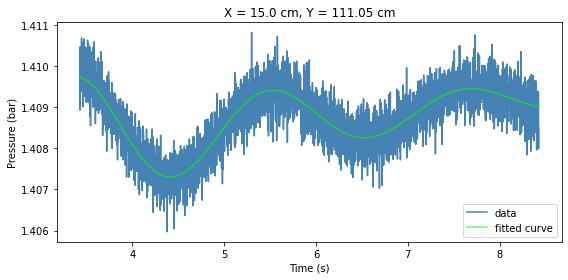

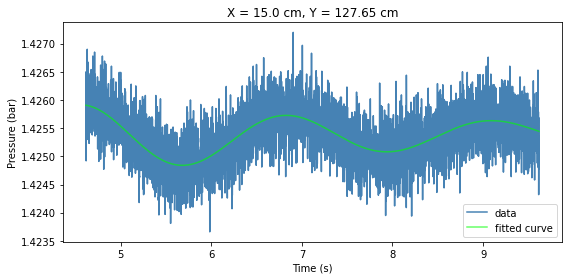

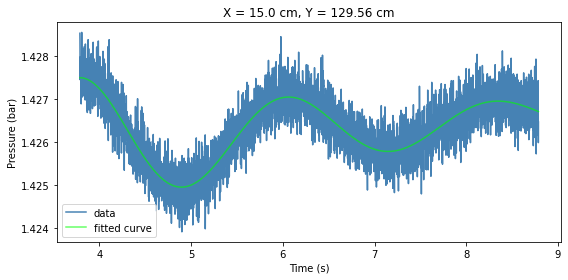

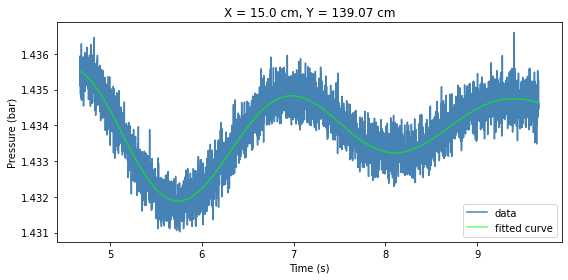

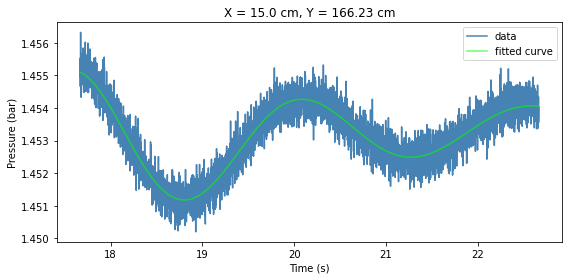

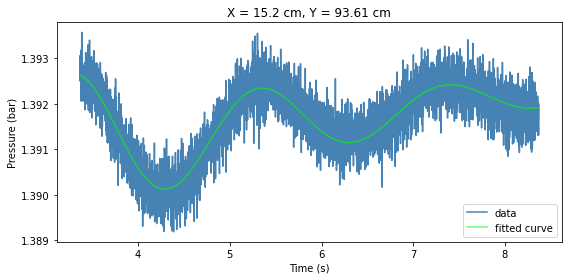

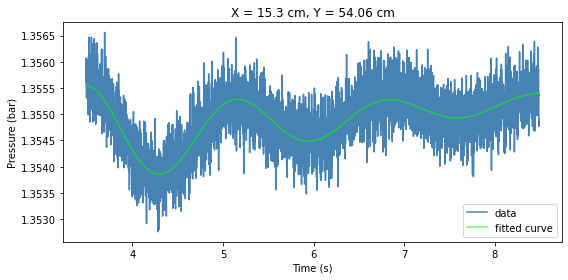

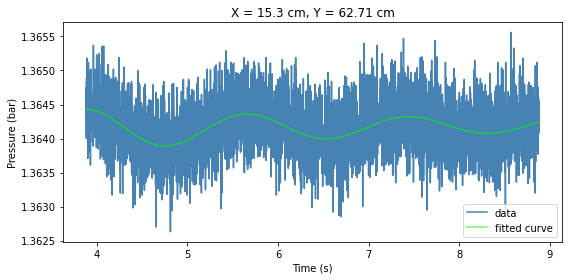

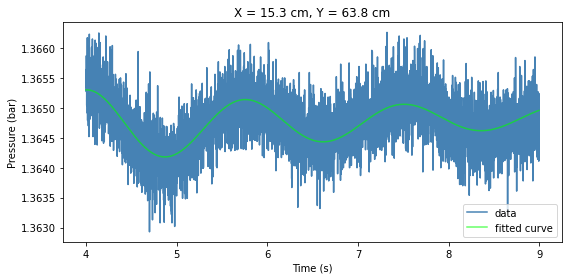

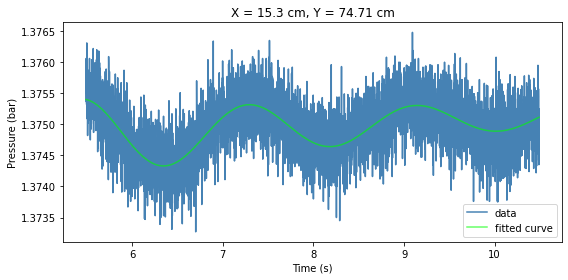

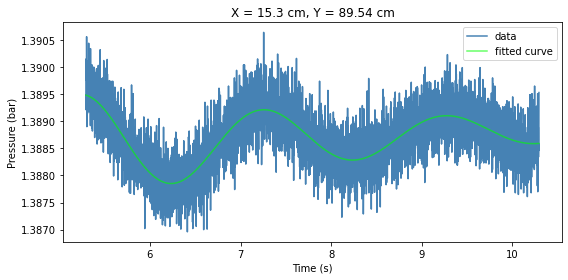

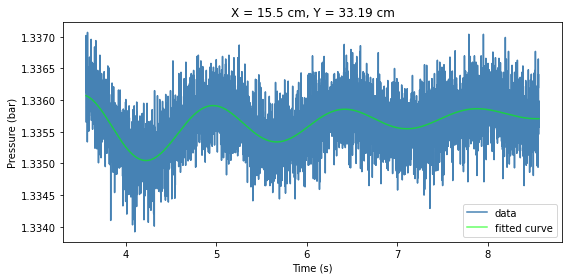

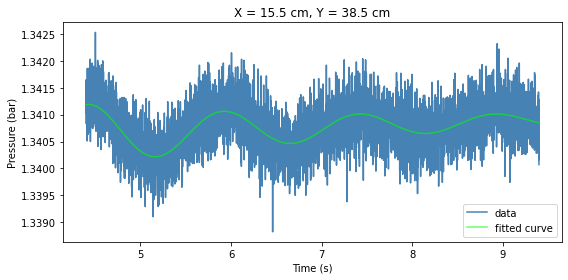

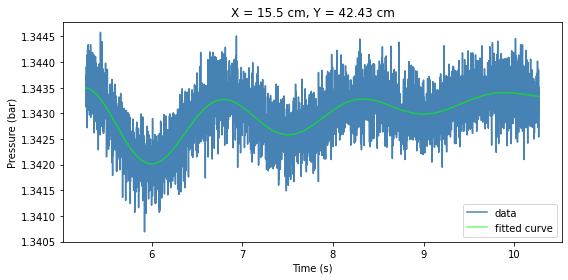

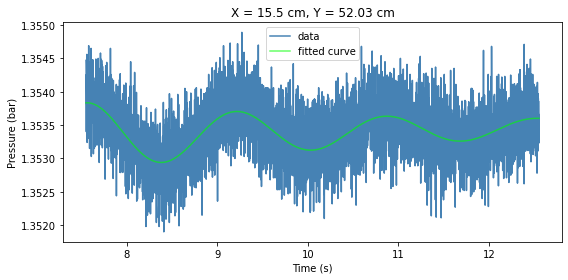

In [41]:
# Keep track of the directory with relevant .bin files
parent_dir = r"C:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\04-21"

# List that stores all the test data, seperated by commas (,), to be dumped into .csv
# Header information for data string.
test_summary = ['X (cm),Adjusted Y (cm),stdev-Y,start,end,A,damp_factor,omega,phi,c,d,stdev-A,stdev-damp,stdev-omega,stdev-phi,stdev-c,stdev-d']

H = 29
osc_details(parent_dir, test_summary, H, verbose=True)

In [42]:
# Writing to .csv file
# Write initial data
csv_name = 'cold-water-freq-constrict-1in_short.csv'
with open(csv_name, 'w') as file_write:
    for test in test_summary:
        file_write.write(test + '\n')

# Algebraically alter params to make an equivalent form
# such that params have physical interpretation.
df = pd.read_csv(csv_name)
for i, data in df.iterrows():
    if data[7] < 0:
        df.iloc[i][7] *= -1
    if df.iloc[i][5] < 0:
        df.iloc[i][5] *= -1
        if df.iloc[i][8] < 0:
            df.iloc[i][8] += np.pi
        else:
            df.iloc[i][8] -= np.pi

# Rewrite new form to the csv
df.to_csv(csv_name, index=False)